<a href="https://colab.research.google.com/github/hiro201025/othello_AI/blob/main/SLpn_CNN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#code: utf-8
from google.colab import drive
import sys
import os
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as albu

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score

#from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as pat
import seaborn as sns

In [ ]:
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks'
CUR_PATH = '/content/gdrive/My Drive/Colab Notebooks/Othello_AI'
if ROOT_PATH not in sys.path:
  sys.path.append(ROOT_PATH)
if CUR_PATH not in sys.path:
  sys.path.append(CUR_PATH)

MODEL_NAME = "conv4_bn_mini"
No = 30
PARAM_NAME = f"SLpn_{MODEL_NAME}_{No}"
PARAM_PATH = os.path.join(CUR_PATH, "SLpn_params", f"{PARAM_NAME}.pth")

Mounted at /content/gdrive


model name:

  conv2_bn:
    15: all data nondup

  conv4_bn:
    30: 30epoch nondup

  conv4_bn_mini:
    20: all data nondup 23:no-transform 30: 30epochs

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
SEED = 2021
set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
import gym
import tools
env = gym.make("othello-v0")

In [ ]:
class Conv4_bn(nn.Module):
  def __init__(self):
    super(Conv4_bn, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(128)

    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(128*8*8, 128)
    self.fc2 = nn.Linear(128, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:
class Conv4_bn_mini(nn.Module):
  def __init__(self):
    super(Conv4_bn_mini, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(64*8*8, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

In [ ]:
class Conv2_bn(nn.Module):
  def __init__(self):
    super(Conv2_bn, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(128)

    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(128*8*8, 128)
    self.fc2 = nn.Linear(128, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:
model_name = MODEL_NAME
if model_name == "conv4_bn":
  model = Conv4_bn().to(device)
elif model_name == "conv4_bn_mini":
  model = Conv4_bn_mini().to(device)
elif model_name == "conv2_bn":
  model = Conv2_bn().to(device)
else:
  print(f"{model_name} not exist.")
  model = 0

model.load_state_dict(torch.load(PARAM_PATH, map_location = device))

<All keys matched successfully>

#view heatmap

In [ ]:
def policy_heatmap(state, pred, posts, player): 
  fig, ax= plt.subplots(1, 1, figsize=(6, 6))
  pred = pred.reshape(8, 8)
  #sns.heatmap(pred, square = True, ax = ax)
  plt.imshow(pred, interpolation='nearest', cmap='magma')
  plt.colorbar()


  for y in range(8):
    for x in range(8):
      st = state[y][x]

      if x + 8*y in posts:
          r = pat.Rectangle(xy=(x-0.4, y-0.4), width=0.8, height=0.8, linewidth=2, ec='g', fill=False)
          ax.add_artist(r)

      if st > 0:
        if st == 1:
          fc, ec = 'w', 'k' #face=white, edge=black
        elif st == 2:
          fc, ec = 'k', 'w'
        c = pat.Circle(xy=(x, y), radius=0.4, fc=fc, ec=ec, fill = True)
        ax.add_artist(c)

  pred_num = np.argsort(-pred.reshape(64))
  for y in range(8):
    for x in range(8):
      px = pred_num[x + y*8] % 8
      py = pred_num[x + y*8] // 8
      ax.text(px-0.25, py+0.25, f"{x + y*8 + 1}", size=10, color='green', fontweight='bold')
  if player == white:
    title = "player: white"
  else:
    title = "player: black"
  ax.set_title(title)
  plt.show()

#VS. Random

In [ ]:
model_info = {"train": "RLpn", "name": "dqn_conv4", "No": 0}

_param_name = f"{model_info['train']}_{model_info['name']}_{model_info['No']}"
_param_path = os.path.join(CUR_PATH, f"{model_info['train']}_params", f"{_param_name}.pth")
if model_info["name"] == "conv4_bn":
  model = Conv4_bn().to(device)
elif model_info["name"] == "conv4_bn_mini":
  model = Conv4_bn_mini().to(device)
elif model_info["name"] == "conv2_bn":
  model = Conv2_bn().to(device)
elif model_info["name"] == "dqn_conv4":
    model = Conv4_bn_mini().to(device)
else:
  print(f"{model_info['name']} not exist.")
  model = None
  
model.load_state_dict(torch.load(_param_path, map_location = device))

<All keys matched successfully>

In [ ]:
white, black = 1, 2
color = ["white", "black"]
AI = black
print(f"AI: {color[AI-1]} {model_info}")

AI: black {'train': 'RLpn', 'name': 'dqn_conv4', 'No': 0}


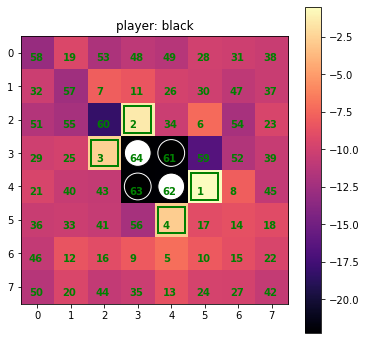

37 37
[29, 43, 45]


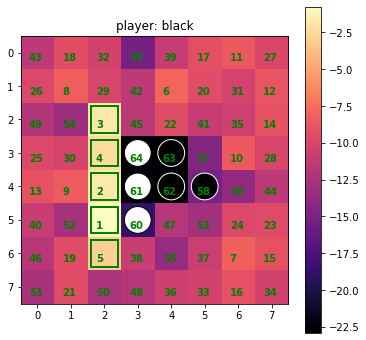

42 42
[29, 41, 45]


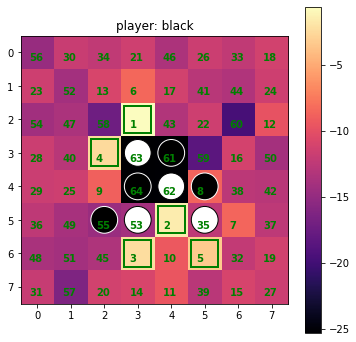

19 19
[11, 18, 20, 29, 34, 38, 41]


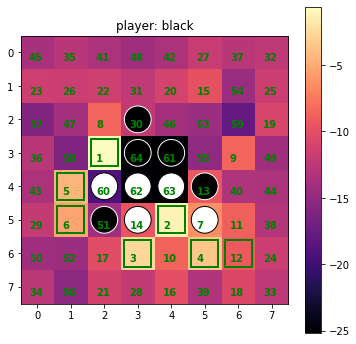

26 26
[11, 17, 18, 20, 21, 25, 29, 33, 38, 41, 49]


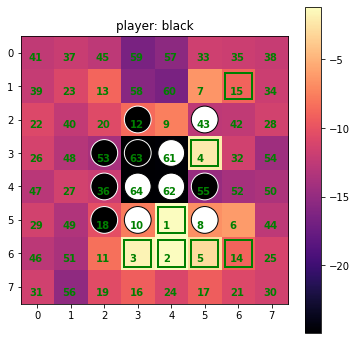

44 44
[10, 18, 25, 29, 33, 38, 41, 46, 49, 50, 52]


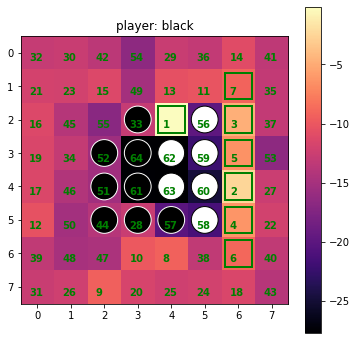

20 20
[10, 11, 18, 25, 33, 41, 49, 50, 51]


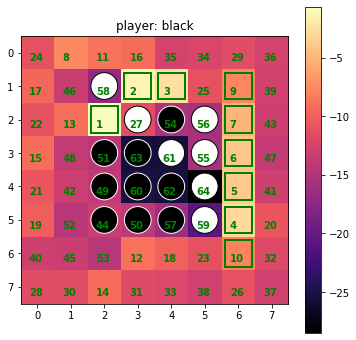

18 18
[9, 11, 12, 17, 25, 33, 41, 49, 50, 51, 52]


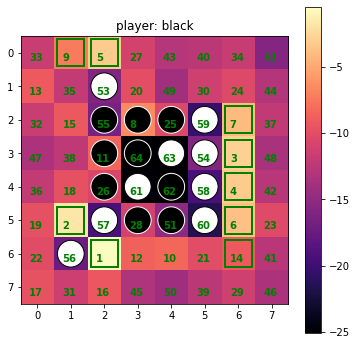

50 50
[9, 11, 12, 17, 25, 33, 41, 51, 52, 53, 57, 58]


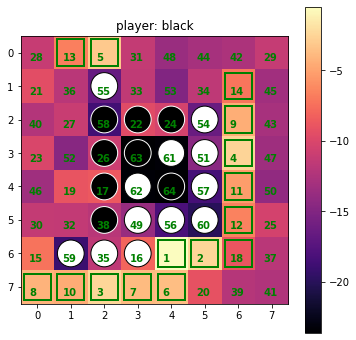

52 52
[9, 11, 12, 17, 25, 33, 41, 53, 59, 60]


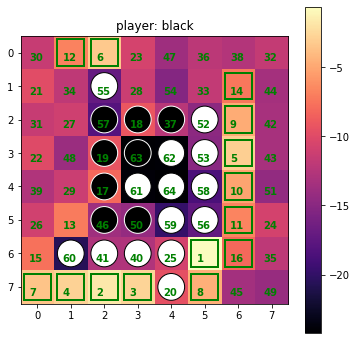

53 53
[9, 11, 12, 17, 25, 33, 41, 46, 54, 61]


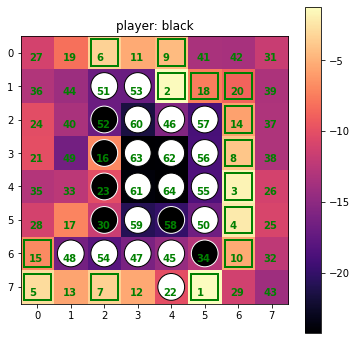

61 61
[9, 17, 25, 33, 41, 46, 54, 59, 62]


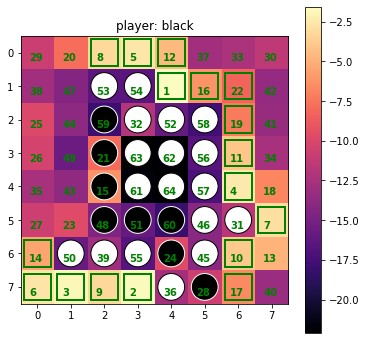

12 12
[3, 4, 9, 13, 17, 25, 33, 41, 59, 62]


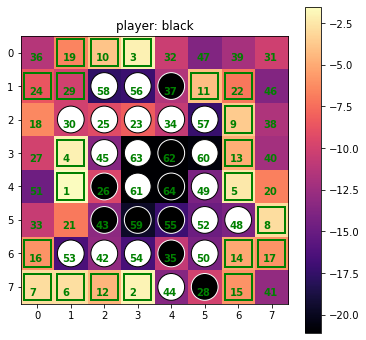

33 33
[3, 4, 13, 24, 25, 32, 41, 59, 62]


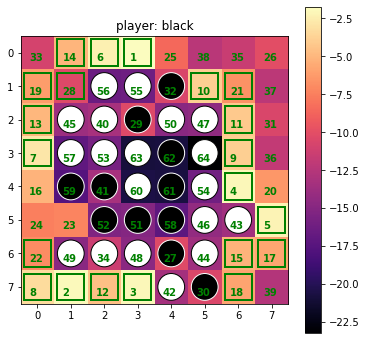

3 3
[2, 4, 5, 13, 24, 32, 40, 41, 59, 62]


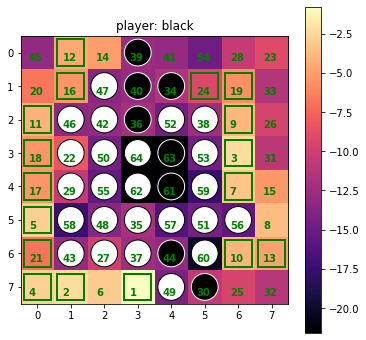

59 59
[2, 4, 5, 13, 58]


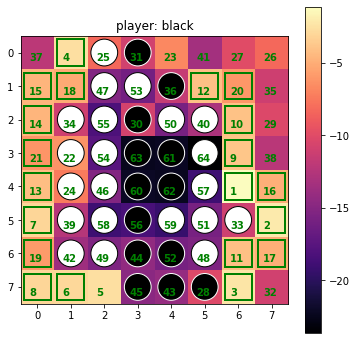

38 38
[4, 5, 13, 30, 39, 47, 54, 58]


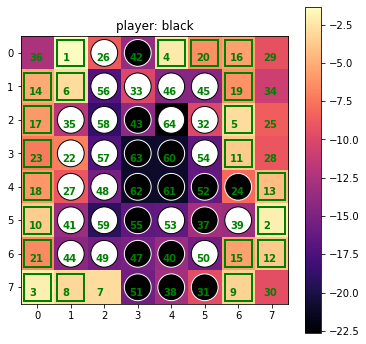

1 1
[9, 30, 39, 47, 54, 58]


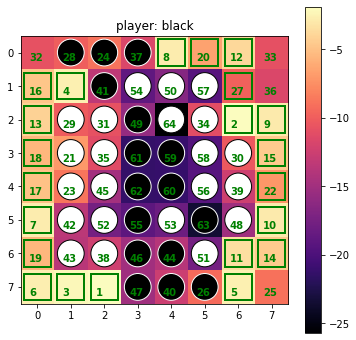

58 58
[9, 57]


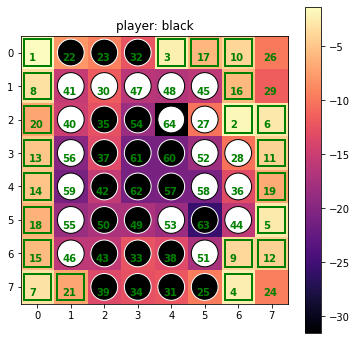

0 0
[8, 57]


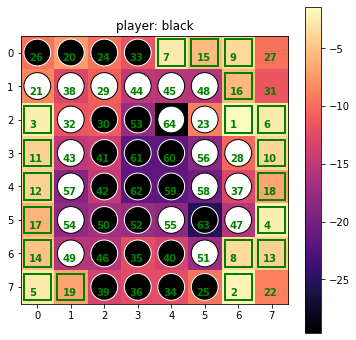

22 22
[14, 23, 31, 54]


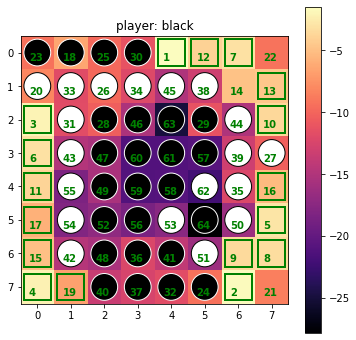

4 4
[5, 14, 54, 57]


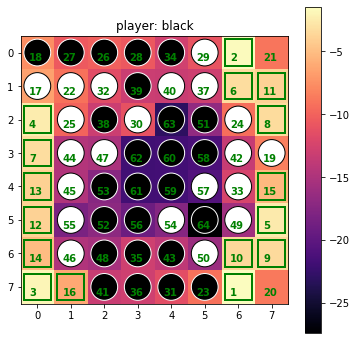

62 62
[14, 54, 57]


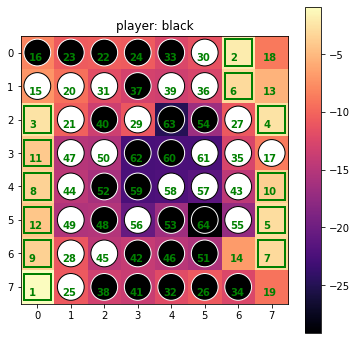

56 56
[48, 54]


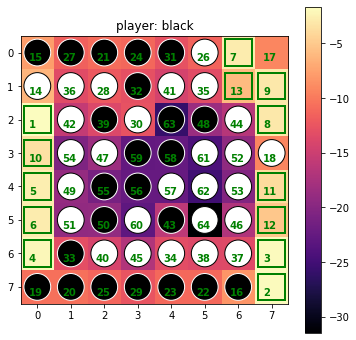

16 16
[24, 48]


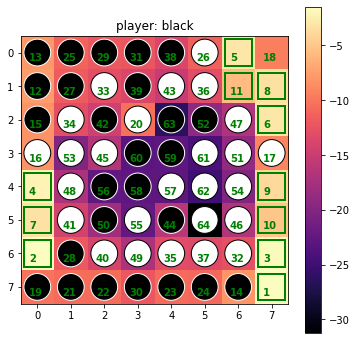

63 63
[48, 55]


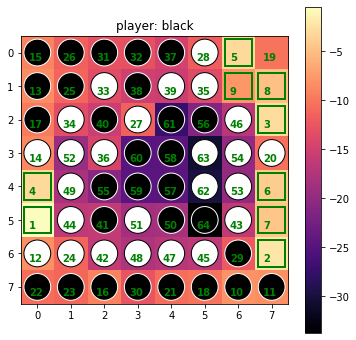

40 40
[32, 55]


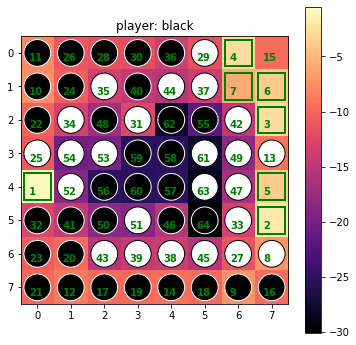

32 32
player: white was skipped


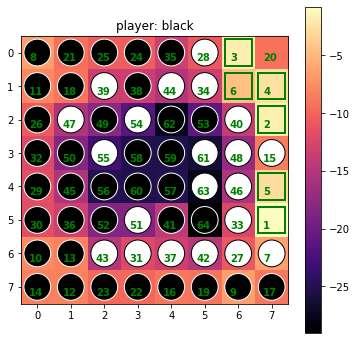

47 47
[39]


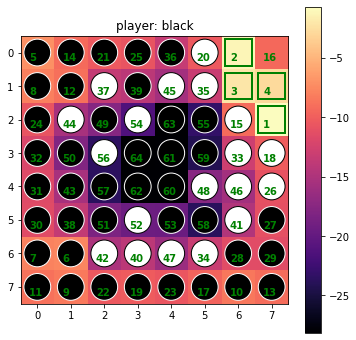

23 23
[14, 15]


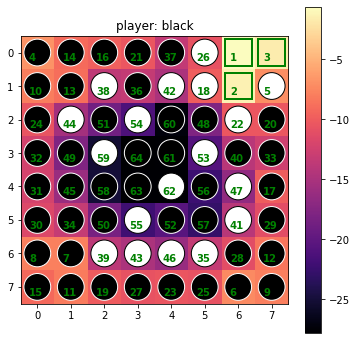

6 6
[14]


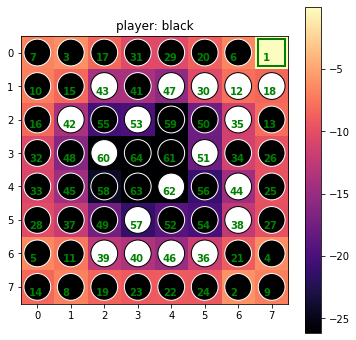

7 7
AI: black
win: white 3 : black 97
acc: 0.9930
Right: 3119 Wrong: 22


In [ ]:
acc = [0, 0] #True, False
win = [0, 0] # white, black
for play in range(100):
  model.eval()
  env.reset()
  while not env.done:
    #env.render()
    player = env.player
    posts, _, _ = env.next_place
    if len(posts) > 0:#black = policy model
      org_state = env.render("rgb_array")
      state = org_state.astype("float32")
      white_st = np.where(state == 3 - player, 1, 0)
      black_st = np.where(state == player, 1, 0)
      bw_st = np.where(state > 0, 1, 0)
      state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8)
      state = torch.tensor(state).float()
      state = state.to(device)
      with torch.no_grad():
        pred = model(state)
        pred_action = pred.max(1)[1].item()
        tposts = torch.tensor([posts]).long().to(device)
        toplace = pred.gather(1, tposts)
        
        pred = nn.LogSoftmax(dim = 1)(pred)
        pred = pred.clone().detach().to('cpu').numpy()
      
      if player == AI:
        if play == 0:
          policy_heatmap(org_state.copy(), pred, posts, player)
        placeid = toplace.max(1)[1]
        action = tposts[0][placeid]
      else:
        if play == 0:
          print(posts)
        action = torch.tensor(-1, device = device, dtype = torch.long)

    else:
      if play == 0:
        print(f"player: {color[player-1]} was skipped")

    _, r_action, _, reward, _, player = env.step(action.item())
    if player != AI:
      if play == 0:
        print(pred_action, r_action)
      if r_action < 0:
        pass
      elif pred_action == r_action:
        acc[0] += 1
      else:
        acc[1] += 1
  winner = (player + (int(reward)+1)//2 )%2 + 1
  winner *= int(reward**2)
  win[winner-1] += 1

#env.render()

print(f"AI: {color[AI-1]}")
print(f"win: white {win[0]} : black {win[1]}")
print(f"acc: {acc[0]/sum(acc):.4f}")
print(f"Right: {acc[0]} Wrong: {acc[1]}")

#Model VS Model 

model name:

surprised train:

conv2_bn: 15: all data nondup

conv4_bn: 30: 30epoch nondup

conv4_bn_mini: 20: all data nondup 23:no-transform 30: 30epochs

conv4_bn_mini = conv2 > conv4_bn

conv4_bn_mini: 20 >= 23 >= 30

in acc: 30 > 20 > 23 ? 

rainforce train:

dqn_conv4: 0

In [ ]:
wmodel = {"train": "RLpn", "name": "dqn_conv4", "No": 1}
bmodel = {"train": "SLpn", "name": "conv4_bn_mini", "No": 30}

models = []
for model_info in (wmodel, bmodel):
  _param_name = f"{model_info['train']}_{model_info['name']}_{model_info['No']}"
  _param_path = os.path.join(CUR_PATH, f"{model_info['train']}_params", f"{_param_name}.pth")
  if model_info["name"] == "conv4_bn":
    model = Conv4_bn().to(device)
  elif model_info["name"] == "conv4_bn_mini":
    model = Conv4_bn_mini().to(device)
  elif model_info["name"] == "conv2_bn":
    model = Conv2_bn().to(device)
  elif model_info["name"] == "dqn_conv4":
    model = Conv4_bn_mini().to(device)
  else:
    print(f"{model_info['name']} not exist.")
    model = None
  
  model.load_state_dict(torch.load(_param_path, map_location = device))
  models.append(model)
print(f"white: {wmodel} black: {bmodel}")

white: {'train': 'RLpn', 'name': 'dqn_conv4', 'No': 1} black: {'train': 'SLpn', 'name': 'conv4_bn_mini', 'No': 30}


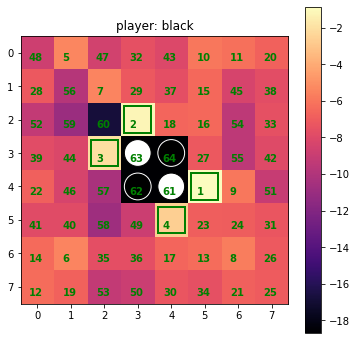

37 37


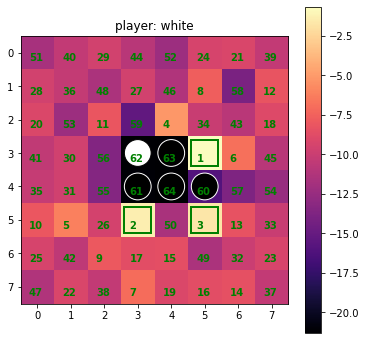

29 29


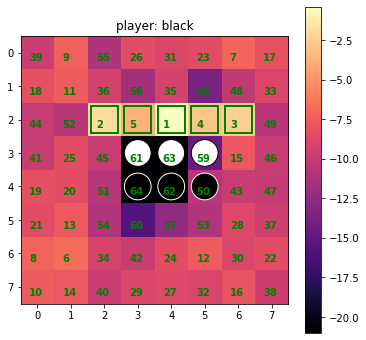

20 20


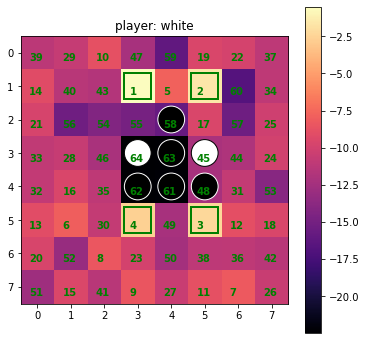

11 11


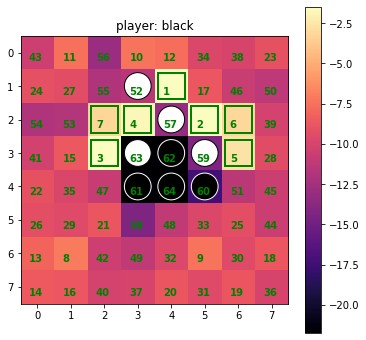

12 12


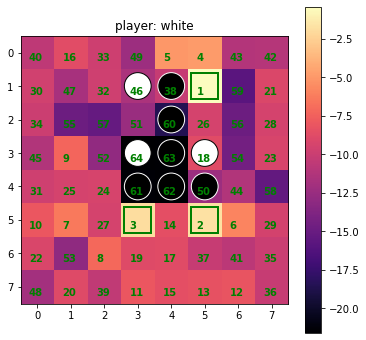

13 13


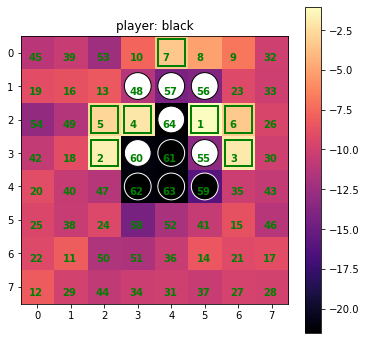

21 21


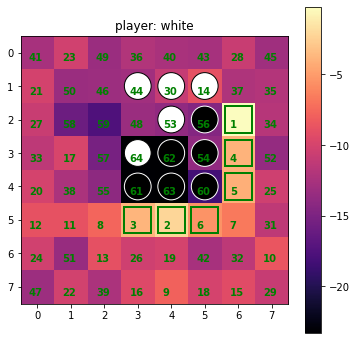

22 22


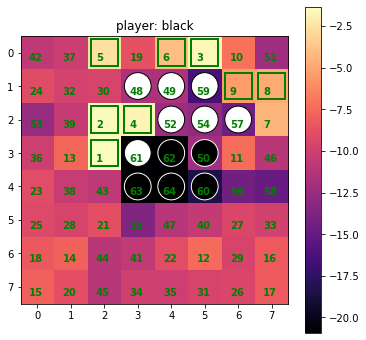

26 26


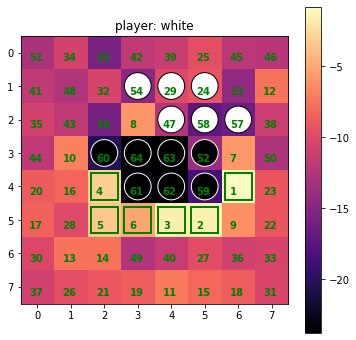

38 38


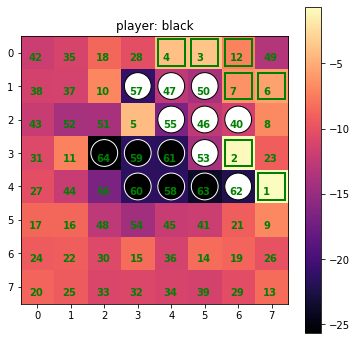

39 39


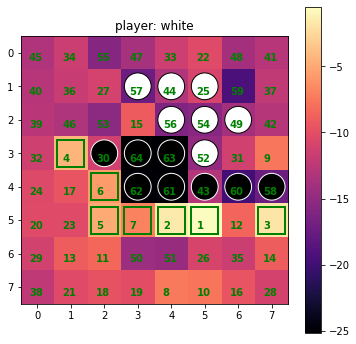

45 45


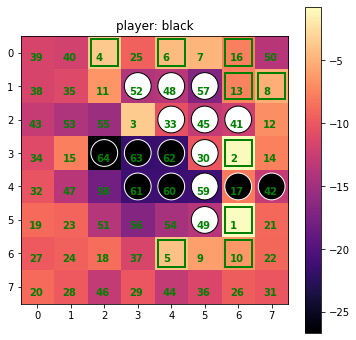

46 46


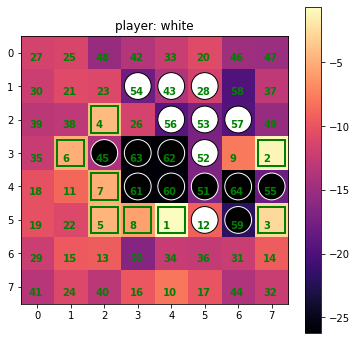

44 44


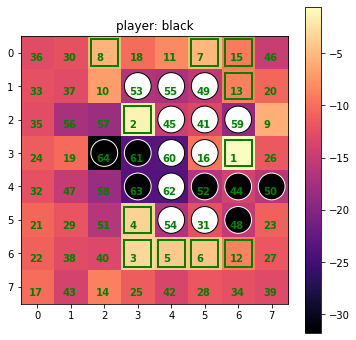

30 30


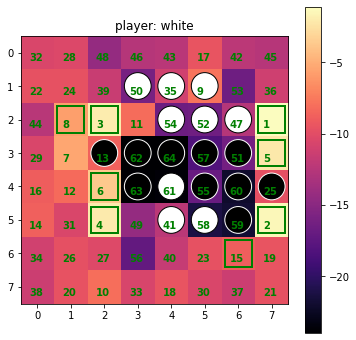

23 23


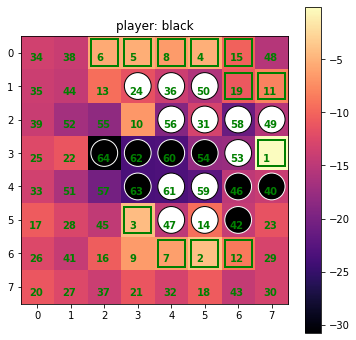

31 31


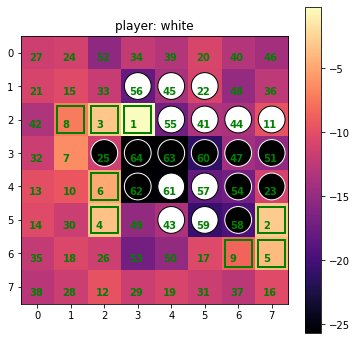

19 19


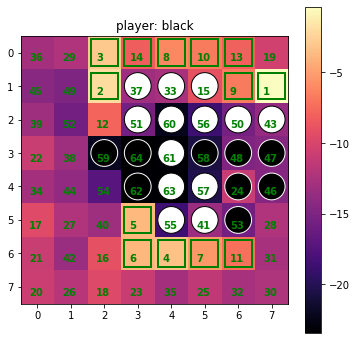

15 15


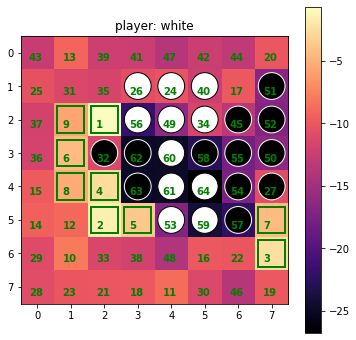

18 18


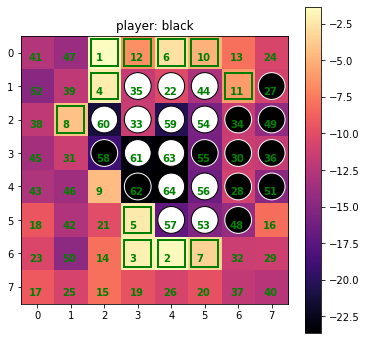

2 2


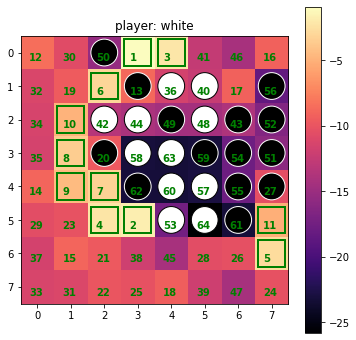

3 3


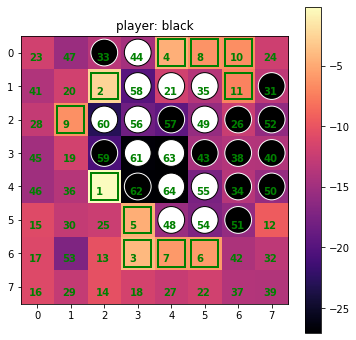

34 34


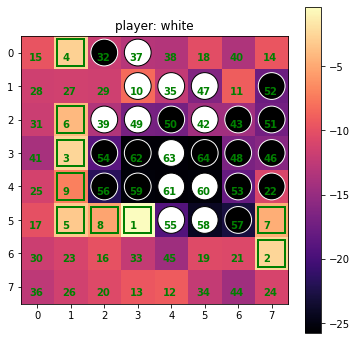

43 43


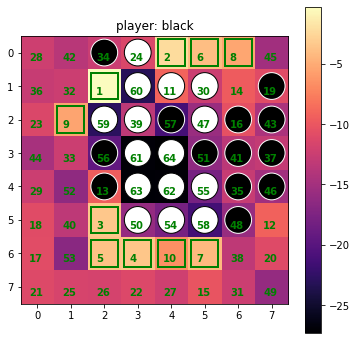

10 10


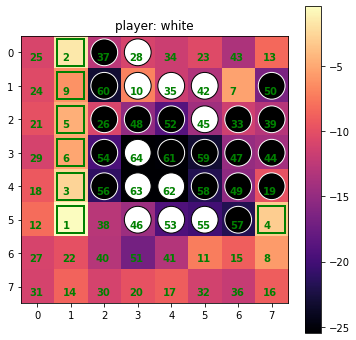

41 41


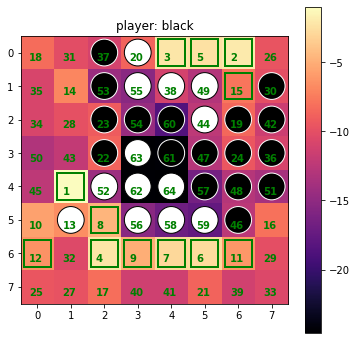

33 33


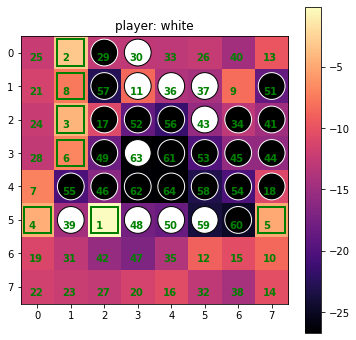

42 42


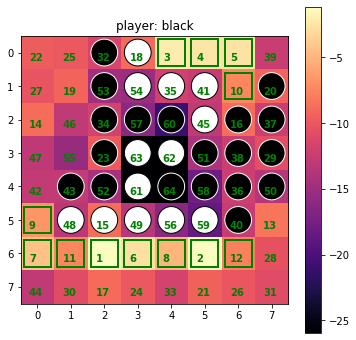

50 50


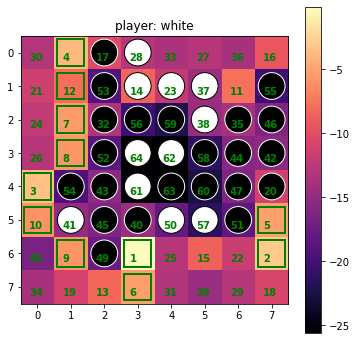

51 51


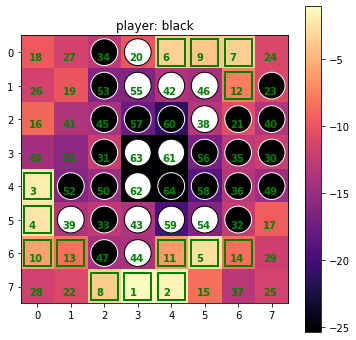

59 59


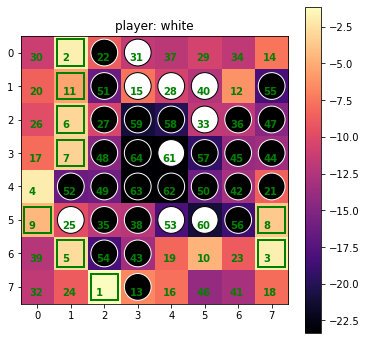

58 58


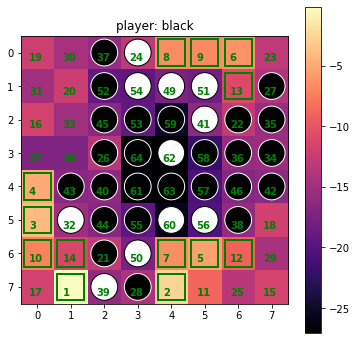

57 57


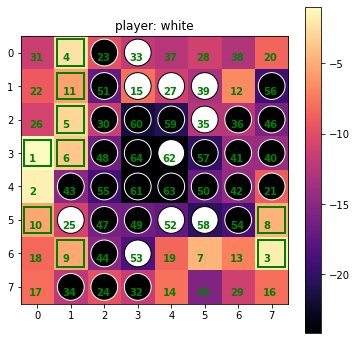

24 24


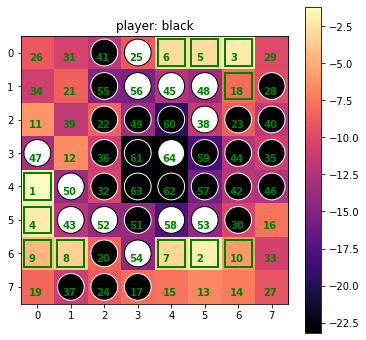

32 32


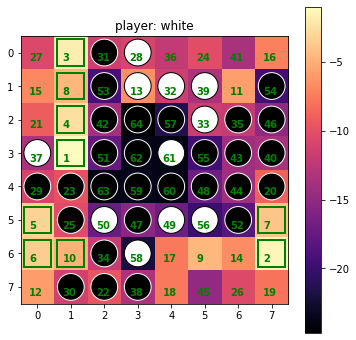

25 25


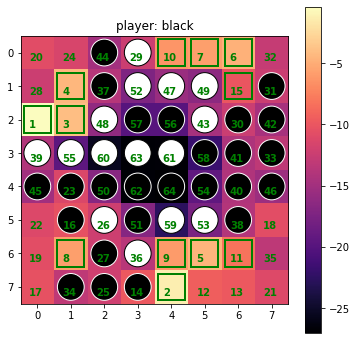

16 16


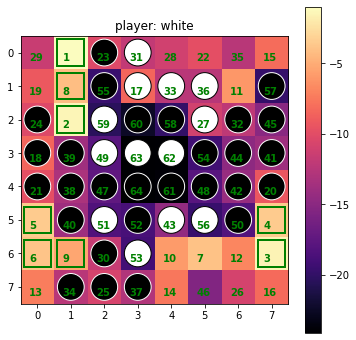

1 1


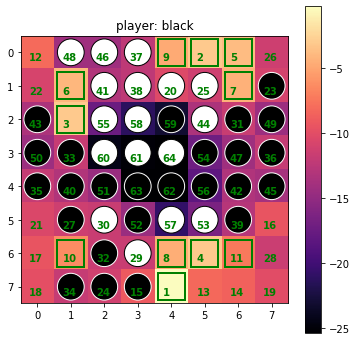

60 60


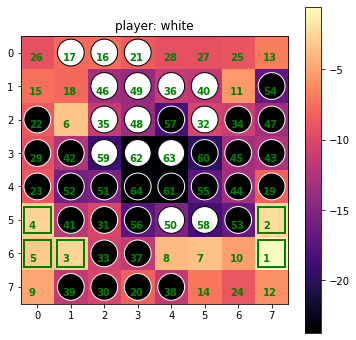

55 55


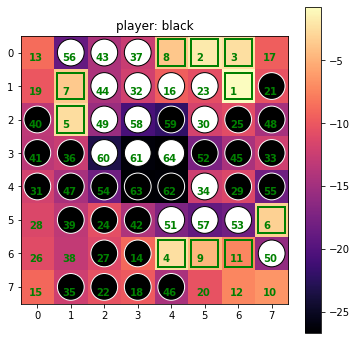

14 14


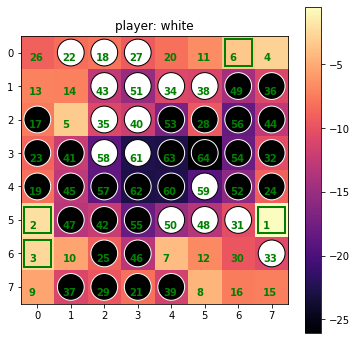

47 47


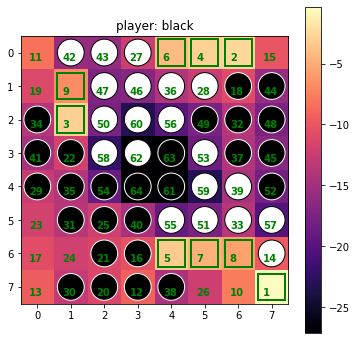

63 63


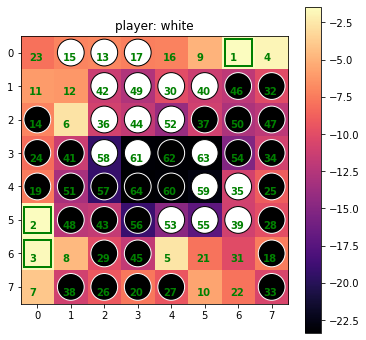

6 6


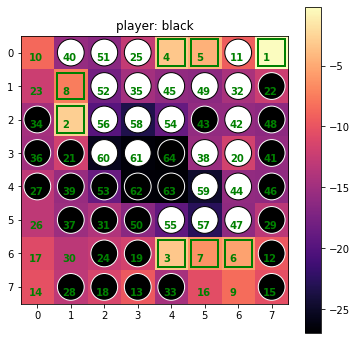

7 7


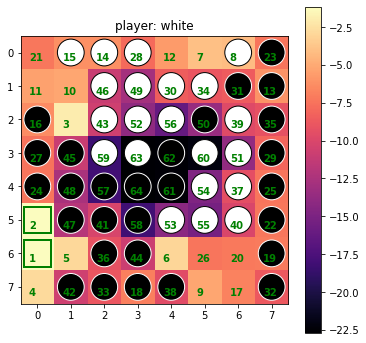

48 48


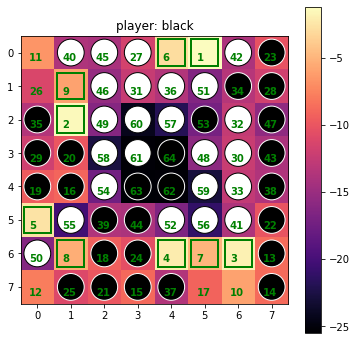

5 5


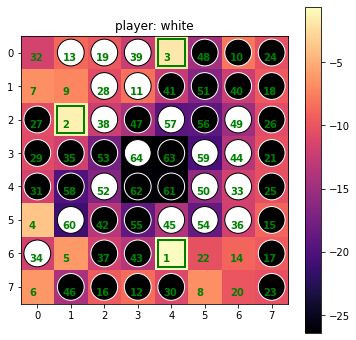

52 52


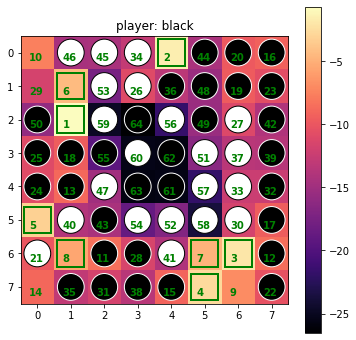

17 17


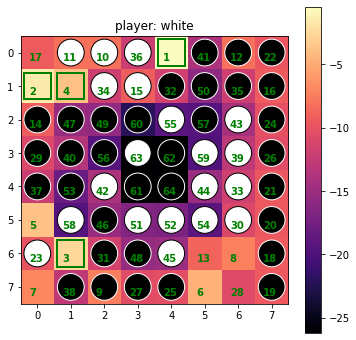

4 4


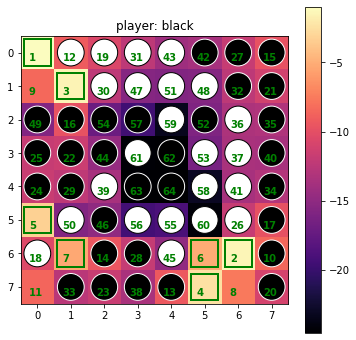

0 0


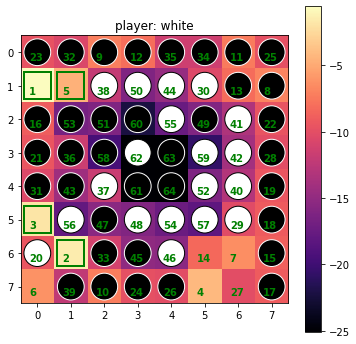

8 8


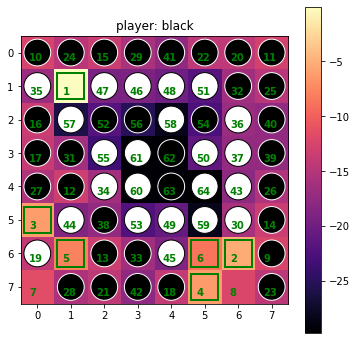

9 9


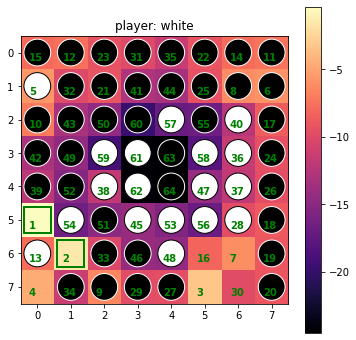

40 40


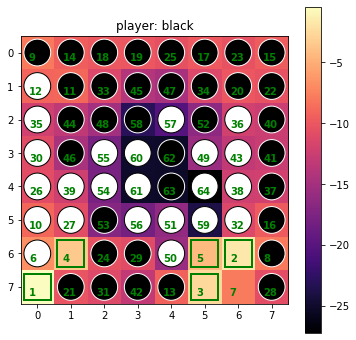

56 56


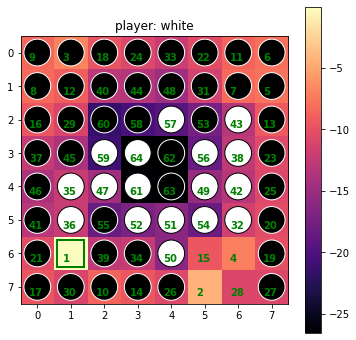

49 49


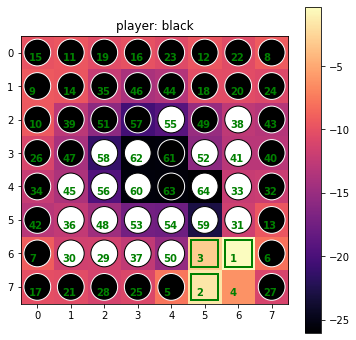

54 54


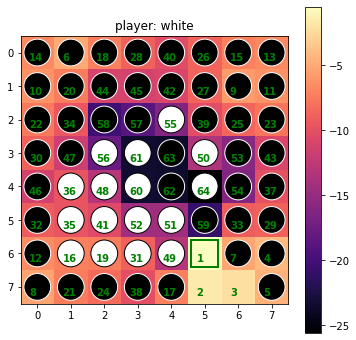

53 53


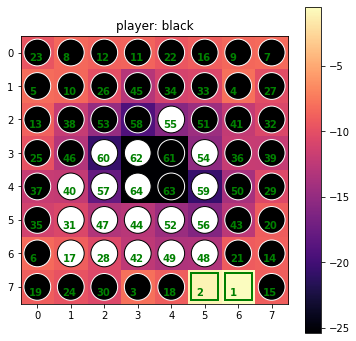

62 62


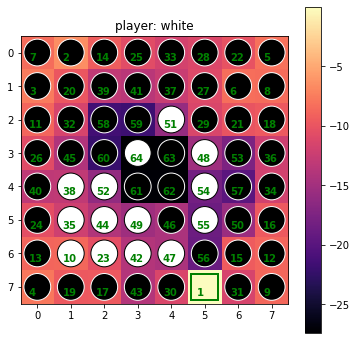

61 61


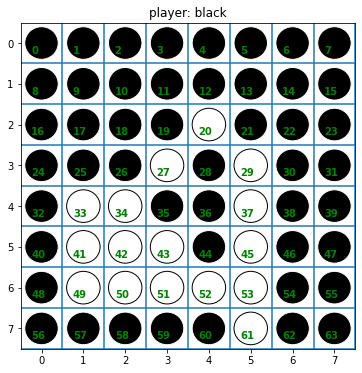

win: black
white acc: 1.0000 Right: 30 Wrong: 0
black acc: 1.0000 Right: 30 Wrong: 0


In [ ]:
acc = [[0, 0], [0,0]] #w, b, True, False
env.reset()
while not env.done:
  #env.render()
  player = env.player
  posts, _, _ = env.next_place
  if len(posts) > 0:#black = policy model
    model = models[player-1]
    model.eval()
    org_state = env.render("rgb_array")
    state = org_state.astype("float32")
    white_st = np.where(state == 3 - player, 1, 0)
    black_st = np.where(state == player, 1, 0)
    bw_st = np.where(state > 0, 1, 0)
    state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8)
    state = torch.tensor(state).float()
    state = state.to(device)
    with torch.no_grad():
      pred = model(state)
      pred_action = pred.max(1)[1].item()
      tposts = torch.tensor([posts]).long().to(device)
      toplace = pred.gather(1, tposts)
      
      pred = nn.LogSoftmax(dim = 1)(pred)
      pred = pred.clone().detach().to('cpu').numpy()
    
    policy_heatmap(org_state.copy(), pred, posts, player)
    placeid = toplace.max(1)[1]
    action = tposts[0][placeid]

  else:
    action = torch.tensor(-1, device = device, dtype = torch.long)
    print(f"player: {color[player-1]} was skipped")

  _, r_action, _, reward, _, player = env.step(action.item())
  print(pred_action, r_action)
  if r_action >= 0:
    if pred_action == r_action:
      acc[player-1][0] += 1
    else:
      acc[player-1][1] += 1

env.render()

winner = (player + (int(reward)+1)//2 )%2 + 1
winner *= int(reward**2)
print(f"win: {color[winner-1]}")
print(f"white acc: {acc[0][0]/sum(acc[0]):.4f} Right: {acc[0][0]} Wrong: {acc[0][1]}")
print(f"black acc: {acc[1][0]/sum(acc[1]):.4f} Right: {acc[1][0]} Wrong: {acc[1][1]}")

#VS. Human

In [ ]:
model_info = {"train": "RLpn", "name": "dqn_conv4", "No": 0}

_param_name = f"{model_info['train']}_{model_info['name']}_{model_info['No']}"
_param_path = os.path.join(CUR_PATH, f"{model_info['train']}_params", f"{_param_name}.pth")
if model_info["name"] == "conv4_bn":
  model = Conv4_bn().to(device)
elif model_info["name"] == "conv4_bn_mini":
  model = Conv4_bn_mini().to(device)
elif model_info["name"] == "conv2_bn":
  model = Conv2_bn().to(device)
elif model_info["name"] == "dqn_conv4":
    model = Conv4_bn_mini().to(device)
else:
  print(f"{model_info['name']} not exist.")
  model = None
  
model.load_state_dict(torch.load(_param_path, map_location = device))

<All keys matched successfully>

In [ ]:
AI = black
print(f"AI: {color[AI-1]} {model_info}")

AI: black {'train': 'RLpn', 'name': 'dqn_conv4', 'No': 0}


In [ ]:
 if False: 
  acc = [0, 0] #True, False
  model.eval()
  env.reset()
  while not env.done:
    #env.render()
    player = env.player
    posts, _, _ = env.next_place
    if len(posts) > 0:#black = policy model
      org_state = env.render("rgb_array")
      state = org_state.astype("float32")
      white_st = np.where(state == 3 - player, 1, 0)
      black_st = np.where(state == player, 1, 0)
      bw_st = np.where(state > 0, 1, 0)
      state = np.stack([bw_st, white_st, black_st], axis = 0).reshape(-1, 3, 8, 8)
      state = torch.tensor(state).float()
      state = state.to(device)
      with torch.no_grad():
        pred = model(state)
        pred_action = pred.max(1)[1].item()
        tposts = torch.tensor([posts]).long().to(device)
        toplace = pred.gather(1, tposts)
        
        pred = nn.LogSoftmax(dim = 1)(pred)
        pred = pred.clone().detach().to('cpu').numpy()
      
      policy_heatmap(org_state.copy(), pred, posts, player)
      
      if player == AI:
        placeid = toplace.max(1)[1]
        action = tposts[0][placeid]
      else:
        print(posts)
        act = input("input number to place a stone: ")
        if act.isdecimal():
          act = int(act)
        else:
          act = -1
        action = torch.tensor(act, device = device, dtype = torch.long)

    else:
      print(f"player: {color[player-1]} was skipped")
      

    _, r_action, _, reward, _, player = env.step(action.item())
    if player != AI:
      print(pred_action, r_action)
      if r_action < 0:
        pass
      elif pred_action == r_action:
        acc[0] += 1
      else:
        acc[1] += 1

  env.render()

  winner = (player + (int(reward)+1)//2 )%2 + 1
  winner *= int(reward**2)
  print(f"win: {color[winner-1]}")
  print(f"acc: {acc[0]/sum(acc):.4f}")
  print(f"Right: {acc[0]} Wrong: {acc[1]}")